### double_ITCZ_sea_cycle: meridional structure of the amplitude of the mean seasonal cycle of PR in the eastern Pacific

Computes the meridional root mean square error (RMSE) of eastern Pacific (15°S-15°N) amplitude (standard deviation) of the mean annual cycle (zonal 150-90°W average) precipitation (PR) between model and observations (the time averaging creates a 12 months mean annual cycle time series from which the standard deviation is computed)

This notebook computes the meridional root mean square error (RMSE) of the amplitude of the mean seasonal cycle of precipitation (PR) between model simulations and observations over the eastern Pacific region (15°S–15°N, 150°W–90°W).

The analysis involves:

- Zonal Averaging: Averaging precipitation data between 150°W and 90°W for both model output and observations.
- Seasonal Cycle Analysis: Computing the mean annual cycle (12-month time series) at each latitude by averaging monthly precipitation over the analysis period.
- Amplitude Calculation: Determining the standard deviation of the mean annual cycle at each latitude to quantify its amplitude.
- Meridional RMSE: Calculating the RMSE between model and observational amplitudes to evaluate the model's ability to replicate the observed seasonal cycle.

## Observations and reanalysis datasets used for comparison

The following reference observational datasets are used to evaluate the model simulations:

- **GPCPv2.3 (1979-2018)**: The primary dataset for comparison. The Global Precipitation Climatology Project (GPCP) combines satellite and surface precipitation measurements to provide comprehensive global precipitation data.
  
Additional observational datasets used for comparison include:
- **20CRv2 (1871-2012)**: The 20th Century Reanalysis provides global atmospheric data, including precipitation, based on surface pressure observations and ensemble assimilation techniques.
- **CMAP (1979-2018)**: The CPC Merged Analysis of Precipitation (CMAP) is a blend of gauge and satellite observations, offering global precipitation estimates.
- **ERA-Interim (1979-2018)**: Reanalysis data produced by the European Centre for Medium-Range Weather Forecasts (ECMWF), providing atmospheric variables, including precipitation, based on a large-scale model and historical observations.
- **NCEP2 (1979-2018)** also known as **NCEP-DOE R2**: The second generation of the National Centers for Environmental Prediction (NCEP) reanalysis, offering precipitation and other atmospheric variables.

These datasets provide a range of perspectives on precipitation patterns, helping to assess the model’s performance more robustly.

## Dask Cluster  
Start a cluster with multiple cores 

In [1]:
from dask.distributed import Client, progress
client = Client()
client

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41563 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/41563/status,
Dashboard: /proxy/41563/status,Workers: 4
Total threads: 12,Total memory: 95.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39763,Workers: 0
Dashboard: /proxy/41563/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:36485,Total threads: 3
Dashboard: /proxy/34613/status,Memory: 23.75 GiB
Nanny: tcp://127.0.0.1:35703,


## Datasets

In [2]:
from esmvalcore.dataset import Dataset

In [3]:
model_datasets = {
"ACCESS-ESM1-5": 
    Dataset(
    short_name='pr',
    project='CMIP6',
    mip="Amon",
    exp="historical",
    ensemble="r1i1p1f1",
    timerange="18500101/20150101",
    dataset="ACCESS-ESM1-5",
    grid="gn"
)}

obs_datasets = {
"GPCP-SG": 
    Dataset(
    short_name='pr',
    dataset='GPCP-SG',
    mip="Amon",
    project='OBS',
    type='atmos',
    timerange="19790101/20190101",
    tier=2),
# "NOAA-CIRES-20CR-V2": 
#     Dataset(
#     short_name='pr',
#     dataset='NOAA-CIRES-20CR-V2',
#     mip="Amon",
#     project='OBS6',
#     type='reanaly',
#     timerange="187101/201212",
#     tier=2),
# "CMAP": 
#     Dataset(
#     short_name='pr',
#     dataset='CMAP',
#     mip="Amon",
#     project='OBS6',
#     type='reanaly',
#     timerange="197901/202408",
#     tier=2),
## ERA-Interim not available in Tier2. Conctact NRI
# "ERA-Interim": 
#     Dataset(
#     short_name='pr',
#     dataset='ERA-Interim',
#     mip="Amon",
#     project='OBS6',
#     type='reanaly',
#     timerange="19790101/20190101",
#     tier=3)
}

## Add Ancillary files


In [4]:
for name, dataset in model_datasets.items():
    dataset.add_supplementary(short_name='sftlf', mip="fx")
    dataset.add_supplementary(short_name="areacella", mip="fx")

In [5]:
model_datasets = {name: dataset.load() for name, dataset in model_datasets.items()}
obs_datasets = {name: dataset.load() for name, dataset in obs_datasets.items()}

(for file /g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r1i1p1f1/fx/sftlf/gn/v20191115/sftlf_fx_ACCESS-ESM1-5_historical_r1i1p1f1_gn.nc)


In [6]:
from esmvalcore.preprocessor import detrend
from esmvalcore.preprocessor import meridional_statistics
from esmvalcore.preprocessor import zonal_statistics
from esmvalcore.preprocessor import regrid
from esmvalcore.preprocessor import mask_landsea
from esmvalcore.preprocessor import convert_units
from esmvalcore.preprocessor import extract_region
from esmvalcore.preprocessor import extract_time
from esmvalcore.preprocessor import climate_statistics

import iris
import numpy as np

In [7]:
def preproc1(cube):
    nino3_latext_region = {"start_longitude": 150., "end_longitude": 270., "start_latitude": -15., "end_latitude": 15.}
    cube = extract_time(cube, start_year=1979, start_month=1, start_day=1, end_year=2014, end_month=12, end_day=31)
    cube = mask_landsea(cube, mask_out="land")
    cube = convert_units(cube, units="mm/day")
    cube = climate_statistics(cube, operator="mean", period="monthly")
    cube = regrid(cube, target_grid="1x1", scheme="linear")
    cube = extract_region(cube, **nino3_latext_region)
    cube.coord('month_number').guess_bounds()
    cube = cube.collapsed('month_number', iris.analysis.STD_DEV)
    return cube

def preproc2(cube):
    nino3_latext_region = {"start_longitude": 210., "end_longitude": 270., "start_latitude": -15., "end_latitude": 15.}
    cube = extract_time(cube, start_year=1979, start_month=1, start_day=1, end_year=2014, end_month=12, end_day=31)
    cube = convert_units(cube, units="mm/day")
    cube = mask_landsea(cube, mask_out="land")
    cube = climate_statistics(cube, operator="mean", period="monthly")
    cube = regrid(cube, target_grid="1x1", scheme="linear")
    cube = extract_region(cube, **nino3_latext_region)
    cube.coord('month_number').guess_bounds()
    cube = cube.collapsed('month_number', iris.analysis.STD_DEV)
    cube = zonal_statistics(cube, 'mean')
    
    return cube

# rmse calc from obs
def rmse(obs_cube, model_cube):
    return np.sqrt(np.mean((obs_cube.data - model_cube.data) ** 2))

In [8]:
model_datasets_prep1 = {name: preproc1(dataset) for name, dataset in model_datasets.items()}
obs_datasets_prep1 = {name: preproc1(dataset) for name, dataset in obs_datasets.items()}

model_datasets_prep2 = {name: preproc2(dataset) for name, dataset in model_datasets.items()}
obs_datasets_prep2 = {name: preproc2(dataset) for name, dataset in obs_datasets.items()}

## Diagnostics Level 1

Text(0.5, 0, 'Latitude')

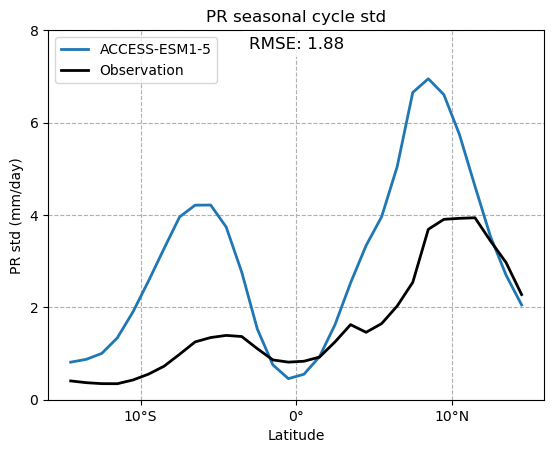

In [9]:
import iris.quickplot as qplt
import matplotlib.pyplot as plt

#plot 1
def format_latitude(x):
    if x < 0:
        return f'{abs(x)}°S'
    elif x > 0:
        return f'{x}°N'
    else:
        return '0°'

obs_data = obs_datasets_prep2["GPCP-SG"]
model_data = model_datasets_prep2["ACCESS-ESM1-5"]
error = rmse(obs_data, model_data)

qplt.plot(model_data, label='ACCESS-ESM1-5', linewidth=2)
qplt.plot(obs_data, color='black', label='Observation', linewidth=2)

plt.text(0.5, 0.95, f'RMSE: {error:.2f}', fontsize=12, ha='center', transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
plt.legend()
# ax = plt.gca()
plt.grid(linestyle='--')
plt.title('PR seasonal cycle std')

plt.yticks(np.arange(0,9, step=2))
plt.ylabel('PR std (mm/day)')

xt = np.arange(-10,15,step=10)
xlab = [format_latitude(x) for x in xt]
plt.xticks(xt,xlab)
plt.xlabel('Latitude')

Figure 1: Meridional bias in the amplitude of the mean seasonal precipitation cycle (PR) in the eastern Pacific (averaged between 150–90°W). The black curve represents the reference data, while the blue curve represents the model data. The metric shown is the meridional RMSE between the model and reference curves.

## Diagnostics level 2

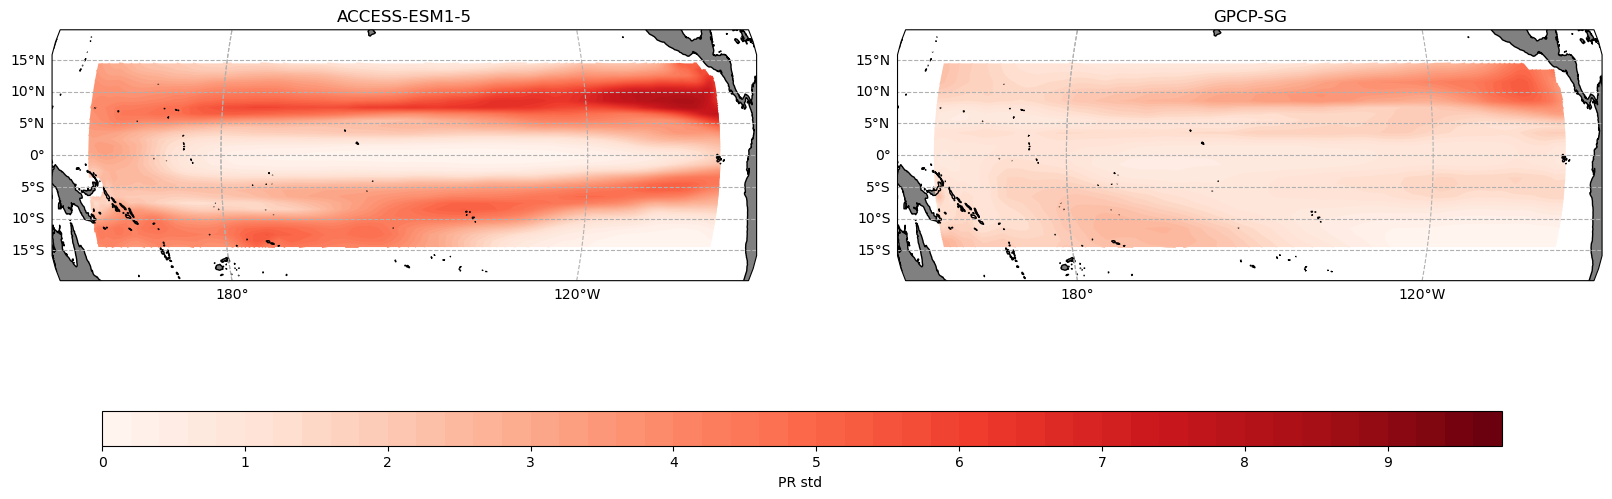

In [10]:
import iris.plot as iplt
import matplotlib.colors as mcolors
import cartopy.feature as cfeature
import cartopy.crs as ccrs

fig = plt.figure(figsize=(20, 7))
proj = ccrs.Orthographic(central_longitude=210.0)
i =121
process = {**model_datasets_prep1, **obs_datasets_prep1}


for label, cube in process.items():
    
    ax1 = plt.subplot(i,projection=proj)
    ax1.add_feature(cfeature.LAND, facecolor='gray')  # Add land feature with gray color
    ax1.coastlines()
    cf1 = iplt.contourf(cube, levels=np.arange(0,10,0.2), cmap='Reds')

    ax1.set_extent([130, 290, -20, 20], crs=ccrs.PlateCarree())
    ax1.set_title(label)

    # Add gridlines for latitude and longitude
    gl1 = ax1.gridlines(draw_labels=True, linestyle='--')
    gl1.top_labels = False
    gl1.right_labels = False

    i+=1


# Add a single colorbar at the bottom
cax = plt.axes([0.15,0.08,0.7,0.05])
cbar = fig.colorbar(cf1, cax=cax, orientation='horizontal', extend='both', ticks=np.arange(0,10,1))
cbar.set_label('PR std ')

Figure 2: Bias in the amplitude of the mean seasonal cycle of precipitation (PR) in the equatorial Pacific. The left map shows the reference data, while the right map displays the model data.

In [11]:
# 3D Visualization
import accessvis
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import os
import pandas as pd
import os
import xarray as xr
import lavavu

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as mcolors
import cmocean
from skimage.transform import resize

from tqdm import tqdm
from scipy.ndimage import gaussian_filter

obs_data = obs_datasets_prep1["GPCP-SG"]
model_data = model_datasets_prep1["ACCESS-ESM1-5"]

padded_obs_data = np.pad(obs_data.data, pad_width=((75, 75), (150, 90)), mode='constant', constant_values=0)
padded_model_data = np.pad(model_data.data, pad_width=((75, 75), (150, 90)), mode='constant', constant_values=0)


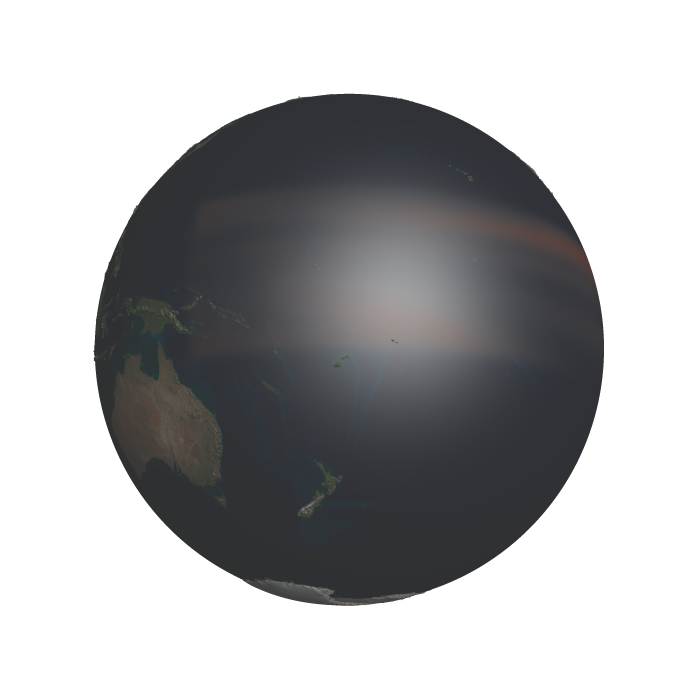

In [12]:
lv = accessvis.plot_earth(texture='bluemarble', background="white", vertical_exaggeration=20)
lv.rotation(15.0, -180.0, 0.0) #Rotate to Australia
lv.set_properties(diffuse=0.8, ambient=0.1, specular=0.35, shininess=0.03, light=[1,1,0.98]) # make pretty
lv.brightness_contrast_saturation(0.5, 0.3, 0.45)
cmap = plt.get_cmap('Reds')
smoothed = gaussian_filter(padded_obs_data, sigma=1.0)
colours_model = accessvis.array_to_rgba(smoothed, flip=True, colourmap=cmap, opacitymap=True, minimum=0, maximum=10)
accessvis.update_earth_values(lv, dataMode=0, data=colours_model)

lv.display(resolution=(700,700))


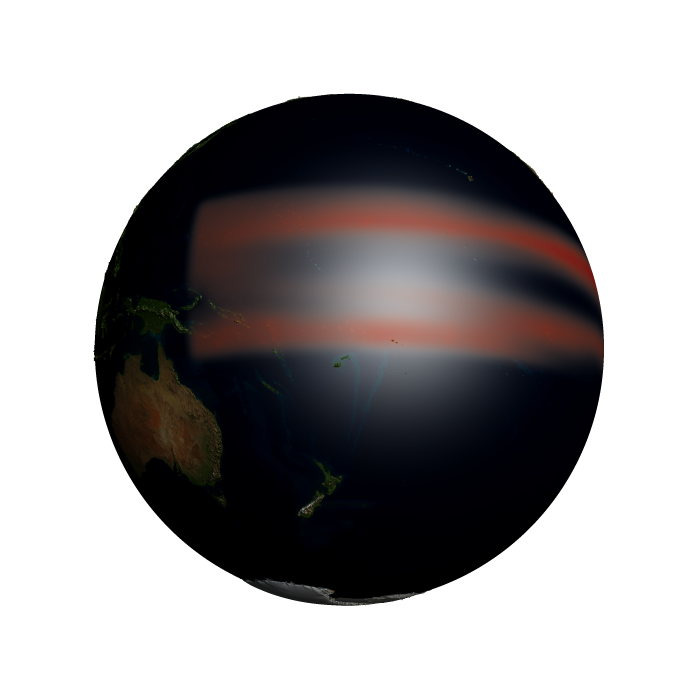

In [13]:
lv = accessvis.plot_earth(texture='bluemarble', background="white", vertical_exaggeration=20)
lv.rotation(15.0, -180.0, 0.0) #Rotate to Australia
lv.set_properties(diffuse=0.8, ambient=0.1, specular=0.35, shininess=0.03, light=[1,1,0.98]) # make pretty
lv.brightness_contrast_saturation(0.5, 0.5, 0.65)
cmap = plt.get_cmap('Reds')
smoothed = gaussian_filter(padded_model_data, sigma=1.0)
colours_model = accessvis.array_to_rgba(smoothed, flip=True, colourmap=cmap, opacitymap=True, minimum=0, maximum=10)
accessvis.update_earth_values(lv, dataMode=0, data=colours_model)

lv.display(resolution=(700,700))

# Diagnostic level 3

The third level shows the meridional structure of the mean seasonal cycle in a Hovmöller diagram

In [11]:
def preproc3(cube):
    nino3_latext_region = {"start_longitude": 210., "end_longitude": 270., "start_latitude": -15., "end_latitude": 15.}
    cube = convert_units(cube, units="mm/day")
    cube = mask_landsea(cube, mask_out="land")
    cube = climate_statistics(cube, operator="mean", period="monthly")
    cube = regrid(cube, target_grid="1x1", scheme="linear")
    cube = extract_region(cube, **nino3_latext_region)
    cube = zonal_statistics(cube, operator='mean')
    
    return cube

model_datasets_prep3 = {name: preproc3(dataset) for name, dataset in model_datasets.items()}
obs_datasets_prep3 = {name: preproc3(dataset) for name, dataset in obs_datasets.items()}
process = {**model_datasets_prep3, **obs_datasets_prep3}

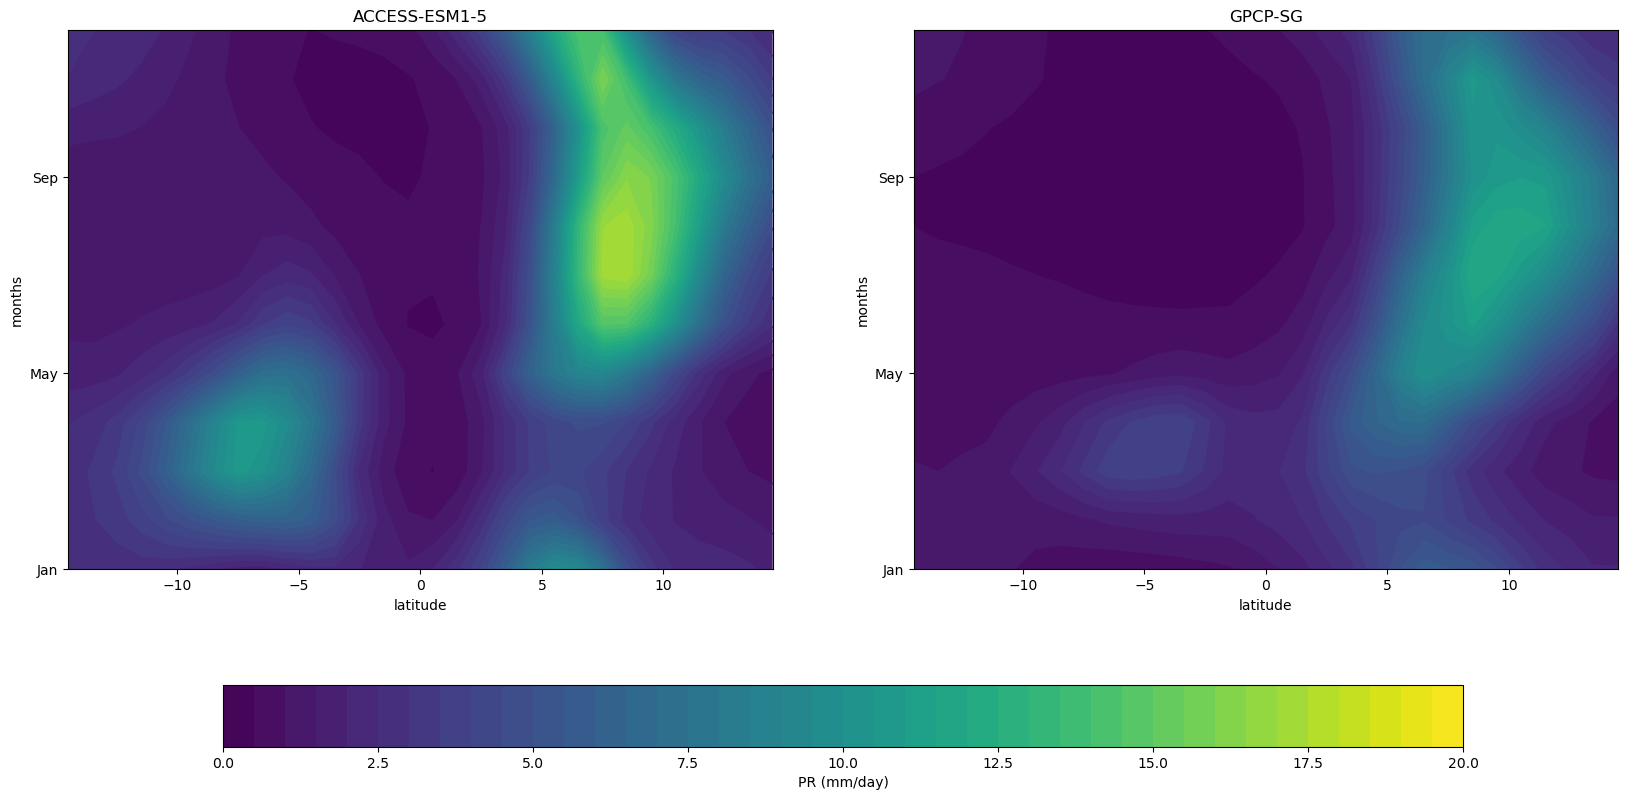

In [12]:
fig = plt.figure(figsize=(20, 10))
i=121

# Define tick positions and labels for the y-axis (months)
month_ticks = np.arange(1, 13, 4)
month_labels =['Jan', 'May', 'Sep'] 
# ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                # 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

axls =[]
for label, cube in process.items():
    
    ax1 = plt.subplot(i)
    cf1 = iplt.contourf(cube,coords=['latitude','month_number'],levels=np.arange(0,20.5,0.5),cmap="viridis")
    ax1.set_ylim(1, 12)
    ax1.set_yticks(ticks=month_ticks, labels=month_labels)
    ax1.set_title(label)
    ax1.set_ylabel("months")
    ax1.set_xlabel("latitude")
    axls.append(ax1)
    i+=1

# Add a single colorbar at the bottom
cbar = fig.colorbar(cf1, ax=axls, orientation='horizontal',shrink=0.8, extend='both')
cbar.set_label('PR (mm/day)')

Figure 3: Meridional structure of the mean seasonal cycle of precipitation (PR) in the eastern Pacific (averaged between 150–90°W). The left map represents the reference data, while the right map shows the model data.